ede2110 emile esmaili


Notebook pipeline: 

- Subtype classification with L1-Logit
- Feature importance with SHAP
- Most important genes embedded with BERT
- embeddings dim reduced
- Clustering of reduced embeddings

# TODO

- get table with longer descriptions
- use BioBERT or BlueBERT



# Imports

In [99]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import shap 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns

from sklearn.preprocessing import StandardScaler

sc.settings.verbosity = 3 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

In [7]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707


In [8]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose().dropna(axis=1)
df_clean.head()

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,-6.6197,0.1185,0.8030,1.9096,1.1627,-1.2910,-1.1661,-24.2671,-0.8905,-0.7464,...,-1.0345,-1.3155,-0.0235,0.7347,0.2169,-1.2143,0.4502,-0.8102,-1.2280,1.0099
TCGA-CS-4941-01,-6.6197,2.0342,0.6853,0.2687,-1.7875,-0.3693,0.5989,-24.2671,-0.2931,-0.8891,...,0.5681,-0.3297,0.9896,0.3312,-0.0860,-0.7410,0.9028,0.9552,0.1514,1.5061
TCGA-CS-4942-01,-6.6197,0.5116,-0.3650,0.7763,-0.0135,-1.8175,-2.1143,-24.2671,-1.0988,-0.8873,...,-0.2736,0.3326,1.1601,0.2281,-0.5701,-0.7399,0.6187,-0.1635,-0.5145,0.5814
TCGA-CS-4943-01,-6.6197,0.1034,-1.5341,1.9239,1.1169,-2.5350,-1.3505,-24.2671,-1.3783,-1.6739,...,2.9808,2.6781,0.6371,0.5073,0.1360,1.0996,0.9174,-0.2393,0.5748,0.5170
TCGA-CS-4944-01,-6.6197,-3.1094,1.2744,1.2506,1.0094,-2.5886,-2.1143,-24.2671,-0.4584,-1.6739,...,-1.6638,-1.1717,-0.8581,-0.9870,-0.9546,-0.5623,-0.1225,-0.6971,-2.9617,-0.5319


## Preprocess pipeline - Genomics + Clinical

In [9]:

## read patient data and preprocessing...

# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()



raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

df_sample_with_gene = df_clean.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})


X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

If there is NA values: False


## Import gene decription

In [10]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
df_gene_reference.head()
#df_gene_description = df_clean.merge(df_gene_reference, how = "left", left_on = "Entrez_Gene_Id", right_on = "NCBI GeneID")

# here is the table with the description:
#df_important_gene_description.head(10)

,NCBI GeneID,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,7157,TP53,tumor protein p53,Homo sapiens,PROTEIN_CODING,7157.0,NCBI Ortholog
1,1956,EGFR,epidermal growth factor receptor,Homo sapiens,PROTEIN_CODING,1956.0,NCBI Ortholog
2,7124,TNF,tumor necrosis factor,Homo sapiens,PROTEIN_CODING,7124.0,NCBI Ortholog
3,348,APOE,apolipoprotein E,Homo sapiens,PROTEIN_CODING,348.0,NCBI Ortholog
4,7422,VEGFA,vascular endothelial growth factor A,Homo sapiens,PROTEIN_CODING,7422.0,NCBI Ortholog


# Run a simple classification model, get most important genes

In [11]:
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [12]:
# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_

y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

print("Train score", clf.score(X_train, y_train), "\nTest Score", clf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        42

    accuracy                           0.98       127
   macro avg       0.99      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127

Train score 1.0 
Test Score 0.984251968503937


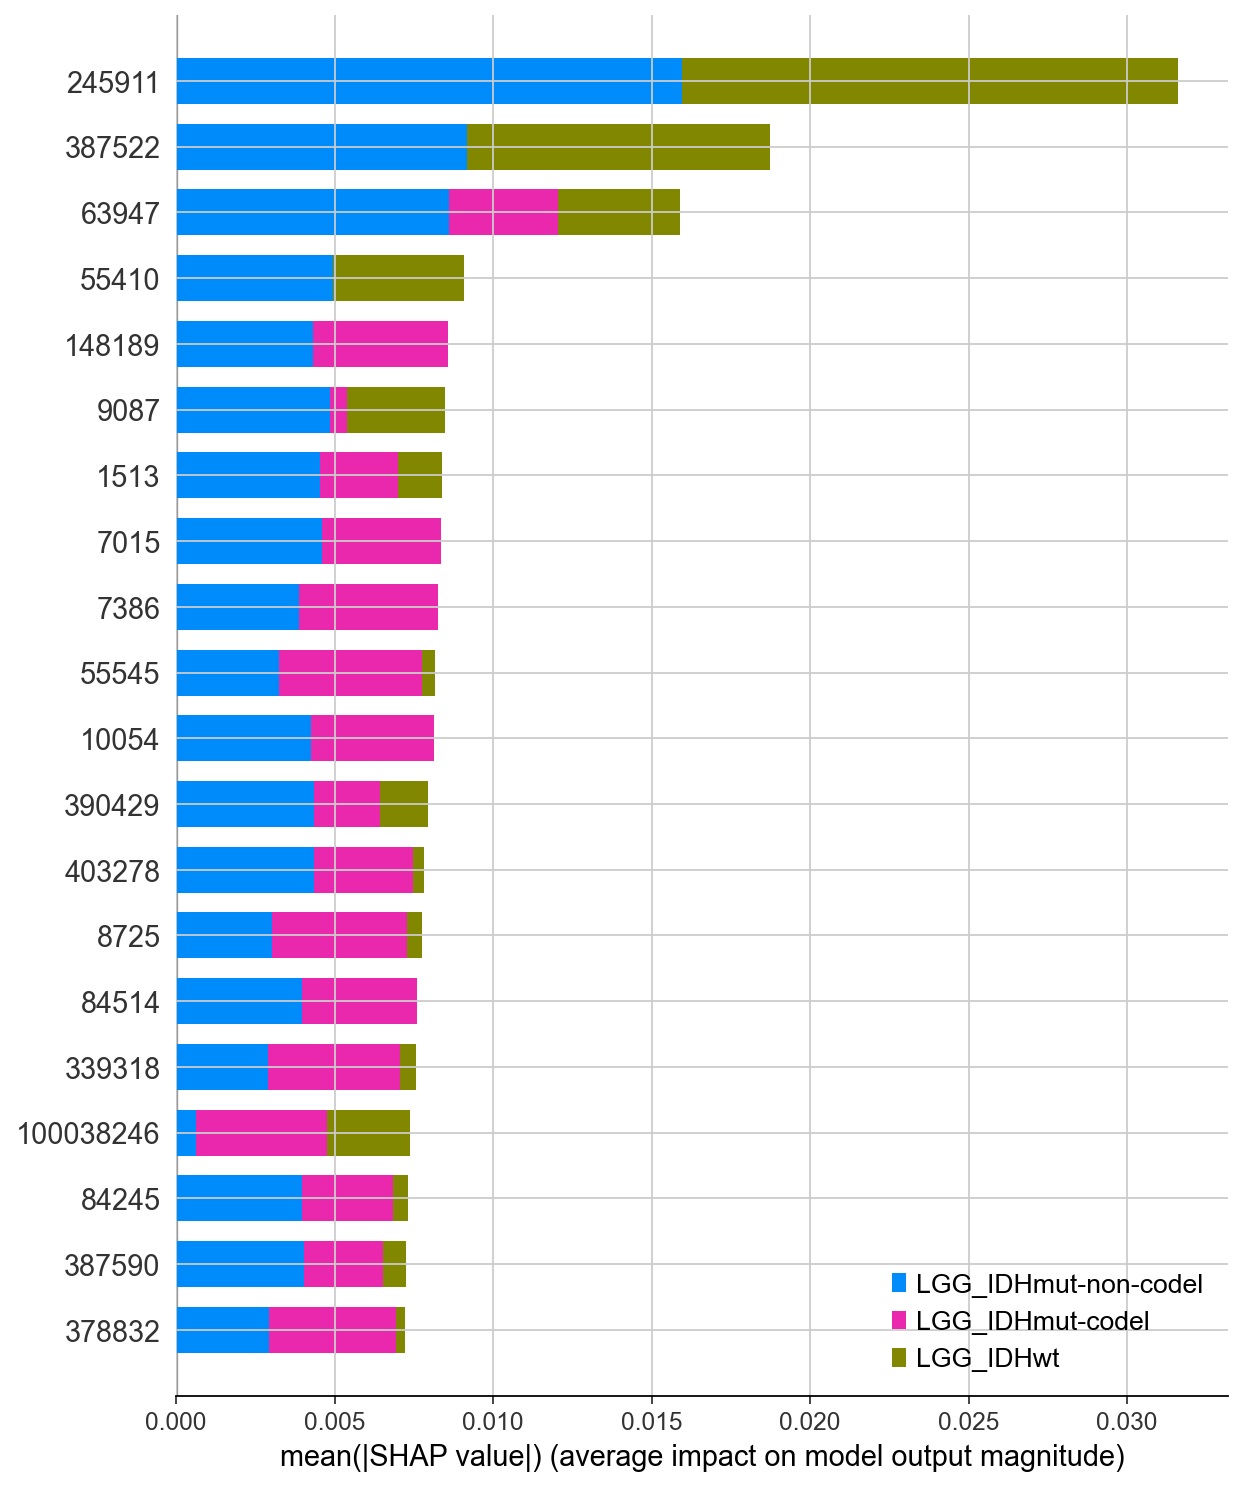

In [13]:
explainer = shap.Explainer(clf, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [112]:
top_n = 100
most_important_genes = pd.merge(feature_importance,df_gene_reference,
                                left_on='gene_id',
                                  right_on='NCBI GeneID').drop(['Taxonomic Name',
                                                                'Gene Group Identifier',
                                                                'Gene Group Method',
                                                                'NCBI GeneID'],
                                                                axis=1
                                                                )
n_most_important_genes = most_important_genes.nlargest(top_n, columns=['feature_importance_vals'])
n_most_important_genes.head(10)

,gene_id,feature_importance_vals,Symbol,Description,Gene Type
0,245911,1.337508,DEFB108B,defensin beta 108B,PROTEIN_CODING
1,387522,0.793047,PEDS1-UBE2V1,PEDS1-UBE2V1 readthrough,PROTEIN_CODING
2,63947,0.673245,DMRTC1,DMRT like family C1,PROTEIN_CODING
3,148189,0.362544,LINC00662,long intergenic non-protein coding RNA 662,ncRNA
4,9087,0.358483,TMSB4Y,thymosin beta 4 Y-linked,PROTEIN_CODING
5,1513,0.354921,CTSK,cathepsin K,PROTEIN_CODING
6,7015,0.353958,TERT,telomerase reverse transcriptase,PROTEIN_CODING
7,7386,0.350201,UQCRFS1,"ubiquinol-cytochrome c reductase, Rieske iron-...",PROTEIN_CODING
8,55545,0.346011,MSX2P1,msh homeobox 2 pseudogene 1,PSEUDO
9,10054,0.344042,UBA2,ubiquitin like modifier activating enzyme 2,PROTEIN_CODING


# pretrained BERT, encode descriptions

In [113]:
model = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')

No sentence-transformers model found with name C:\Users\emile/.cache\torch\sentence_transformers\emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\emile/.cache\torch\sentence_transformers\emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

In [114]:
descriptions = n_most_important_genes['Description']
embeddings = model.encode(descriptions)

In [115]:
embeddings.shape

(100, 768)

# Reduce dim of embeddings then cluster

In [116]:
# Standardize the dataset X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Perform PCA on the standardized dataset X
pca = PCA(n_components=50)
pca.fit(X_scaled)


# Obtain the principal components and the explained variance ratios
principal_components = pca.transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print('explained variance is',explained_variance.sum())

# Create a new DataFrame with the principal components and the "cluster" column
df_pca = pd.DataFrame(data = principal_components)

explained variance is 0.89645404


In [117]:
tsne = TSNE()
embed = tsne.fit_transform(X_scaled)
# Create a new DataFrame with the principal components and the "cluster" column
df_embed = pd.DataFrame(data = embed, columns=['dim1','dim2'])

In [118]:
umapp = umap.UMAP()
embed = umapp.fit_transform(X_scaled)
df_embed = pd.DataFrame(data = embed, columns=['dim1','dim2'])

In [119]:

wcss_pca = []
wcss_umap = []
n_test = 20
# Perform k-means clustering for each k value from 1 to 10
for k in range(1, n_test):
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_pca)
    kmeans_umap = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(embed)
    wcss_pca.append(kmeans_pca.inertia_)
    wcss_umap.append(kmeans_umap.inertia_)

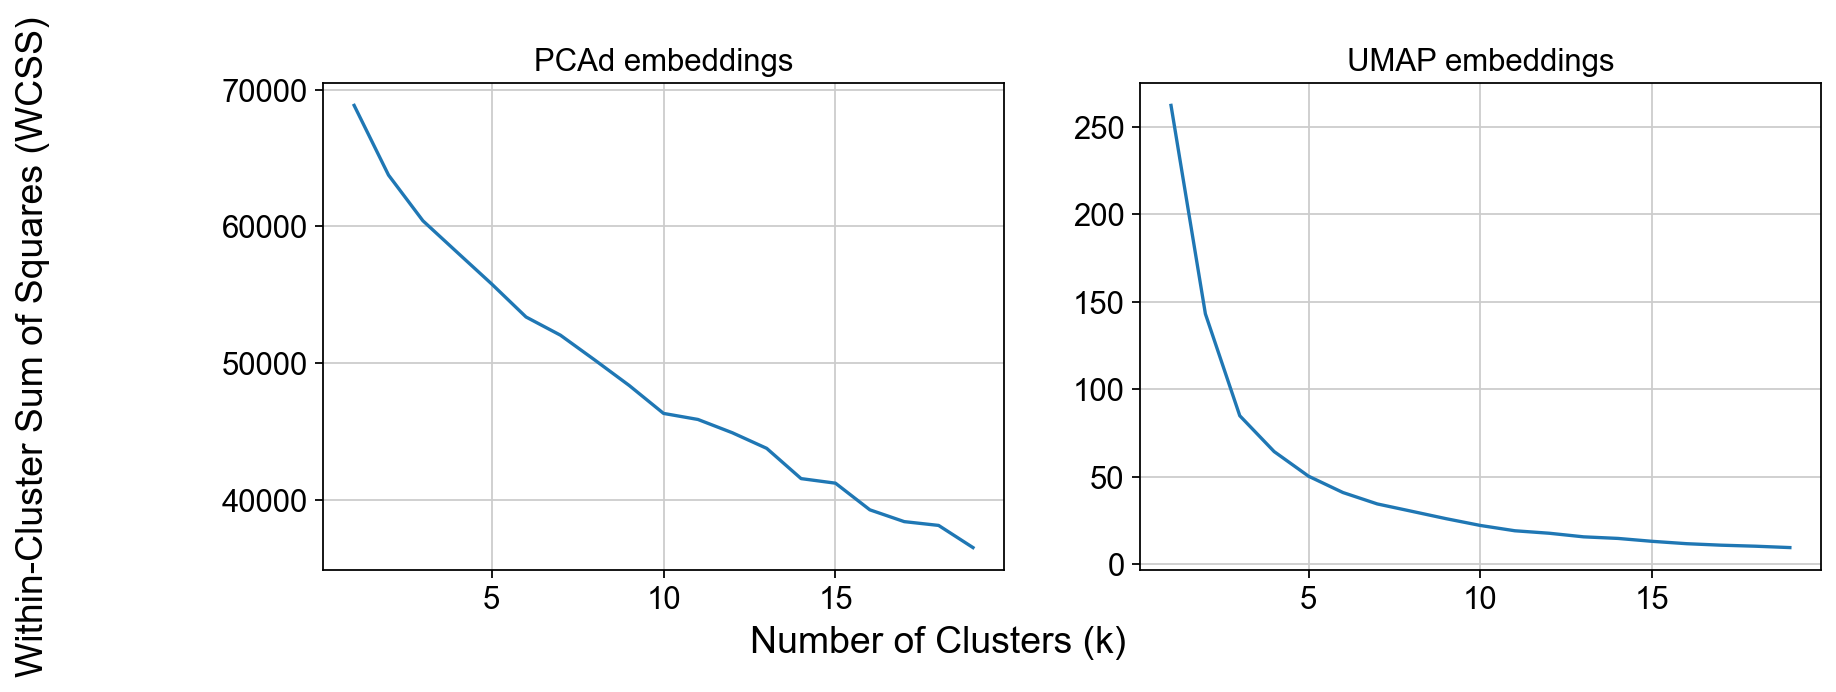

In [120]:
# Create a scree plot
fig, ax = plt.subplots(1,2,sharex=True, figsize=(12,4))
ax[0].plot(range(1, n_test), wcss_pca)
ax[1].plot(range(1, n_test), wcss_umap)
ax[0].set_title('PCAd embeddings')
ax[1].set_title('UMAP embeddings')
fig.supxlabel('Number of Clusters (k)')
fig.supylabel('Within-Cluster Sum of Squares (WCSS)')
#fig.suptitle('Scree Plot with embeddings')
plt.show()

# cluster

In [121]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters).fit(embed)
labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [122]:
clusters_df = pd.concat([n_most_important_genes, df_embed, labels],axis=1)
clusters_df.groupby(by='cluster').count().iloc[:,0]


cluster
0    13
1    17
2    15
3    11
4    11
5     5
6    14
7    14
Name: gene_id, dtype: int64

## Looking at description

In [123]:

clusters_df[clusters_df['cluster']==0]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
0,245911,1.337508,DEFB108B,defensin beta 108B,PROTEIN_CODING,6.301254,1.239586,0
5,1513,0.354921,CTSK,cathepsin K,PROTEIN_CODING,6.540813,1.572604,0
6,7015,0.353958,TERT,telomerase reverse transcriptase,PROTEIN_CODING,5.818105,1.692524,0
19,7268,0.303276,TTC4,tetratricopeptide repeat domain 4,PROTEIN_CODING,5.952475,2.153738,0
28,64211,0.281749,LHX5,LIM homeobox 5,PROTEIN_CODING,6.240855,0.709398,0
35,3209,0.277291,HOXA13,homeobox A13,PROTEIN_CODING,6.067622,0.599439,0
44,729330,0.266829,OC90,otoconin 90,PROTEIN_CODING,6.530130,1.303270,0
46,391322,0.263734,LOC391322,D-dopachrome tautomerase-like,PROTEIN_CODING,5.639761,1.785107,0
50,362,0.259677,AQP5,aquaporin 5,PROTEIN_CODING,6.469396,1.187109,0
53,515,0.258353,ATP5PB,ATP synthase peripheral stalk-membrane subunit b,PROTEIN_CODING,5.486838,1.500203,0


In [124]:
clusters_df[clusters_df['cluster']==1]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
3,148189,0.362544,LINC00662,long intergenic non-protein coding RNA 662,ncRNA,3.060432,0.073836,1
8,55545,0.346011,MSX2P1,msh homeobox 2 pseudogene 1,PSEUDO,3.828330,-0.392465,1
10,390429,0.336478,OR4N2,olfactory receptor family 4 subfamily N member 2,PROTEIN_CODING,4.140721,-0.066156,1
11,403278,0.330624,OR5K4,olfactory receptor family 5 subfamily K member 4,PROTEIN_CODING,4.022471,0.044287,1
12,8725,0.328074,URI1,URI1 prefoldin like chaperone,PROTEIN_CODING,3.857595,0.694836,1
17,387590,0.306887,TPTEP1,TPTE pseudogene 1,PSEUDO,3.685479,-0.298749,1
18,378832,0.305143,COL18A1-AS1,COL18A1 antisense RNA 1,ncRNA,4.216977,0.486715,1
26,2297,0.283868,FOXD1,forkhead box D1,PROTEIN_CODING,4.032397,-0.650329,1
33,26065,0.277696,LSM14A,LSM14A mRNA processing body assembly factor,PROTEIN_CODING,3.724731,0.741370,1
37,79730,0.273089,NSUN7,NOP2/Sun RNA methyltransferase family member 7,PROTEIN_CODING,4.029567,0.523034,1


In [125]:
clusters_df[clusters_df['cluster']==2]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
13,84514,0.321189,GHDC,GH3 domain containing,PROTEIN_CODING,2.777362,1.770809,2
23,54455,0.285481,FBXO42,F-box protein 42,PROTEIN_CODING,2.527529,2.798630,2
30,56181,0.280679,MTFR1L,mitochondrial fission regulator 1 like,PROTEIN_CODING,3.282419,2.339207,2
32,55108,0.278108,BSDC1,BSD domain containing 1,PROTEIN_CODING,2.733091,2.210234,2
36,653567,0.274554,TMEM236,transmembrane protein 236,PROTEIN_CODING,3.351700,1.794806,2
49,54834,0.259691,GDAP2,ganglioside induced differentiation associated...,PROTEIN_CODING,2.929118,1.978433,2
51,84902,0.259624,CEP89,centrosomal protein 89,PROTEIN_CODING,3.551198,1.687450,2
61,11264,0.252192,PXMP4,peroxisomal membrane protein 4,PROTEIN_CODING,3.534067,1.906822,2
62,4037,0.251955,LRP3,LDL receptor related protein 3,PROTEIN_CODING,2.801416,2.823649,2
71,79871,0.247390,RPAP2,RNA polymerase II associated protein 2,PROTEIN_CODING,2.991501,1.580906,2


In [126]:
clusters_df[clusters_df['cluster']==3]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
16,84245,0.309356,MRI1,methylthioribose-1-phosphate isomerase 1,PROTEIN_CODING,5.251958,2.680074,3
22,54101,0.286627,RIPK4,receptor interacting serine/threonine kinase 4,PROTEIN_CODING,4.716101,2.501400,3
25,10352,0.284491,WARS2,"tryptophanyl tRNA synthetase 2, mitochondrial",PROTEIN_CODING,5.998089,2.516849,3
38,1101,0.272120,CHAD,chondroadherin,PROTEIN_CODING,4.932275,3.193525,3
52,84842,0.258871,HPDL,4-hydroxyphenylpyruvate dioxygenase like,PROTEIN_CODING,5.521780,2.515587,3
74,79947,0.246201,DHDDS,dehydrodolichyl diphosphate synthase subunit,PROTEIN_CODING,5.514776,2.845131,3
88,5511,0.235843,PPP1R8,protein phosphatase 1 regulatory subunit 8,PROTEIN_CODING,5.544698,3.049414,3
90,6390,0.234271,SDHB,succinate dehydrogenase complex iron sulfur su...,PROTEIN_CODING,5.116518,2.826061,3
94,9682,0.232408,KDM4A,lysine demethylase 4A,PROTEIN_CODING,5.113866,3.512282,3
95,23028,0.232348,KDM1A,lysine demethylase 1A,PROTEIN_CODING,4.830808,3.448764,3


In [127]:
clusters_df[clusters_df['cluster']==4]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
1,387522,0.793047,PEDS1-UBE2V1,PEDS1-UBE2V1 readthrough,PROTEIN_CODING,5.264581,-0.001522,4
2,63947,0.673245,DMRTC1,DMRT like family C1,PROTEIN_CODING,4.898222,-0.354973,4
15,100038246,0.311905,TLX1NB,TLX1 neighbor,ncRNA,5.340065,-0.054885,4
24,390790,0.285384,ARL5C,ADP ribosylation factor like GTPase 5C,PROTEIN_CODING,5.372661,0.472078,4
34,134266,0.277335,GRPEL2,"GrpE like 2, mitochondrial",PROTEIN_CODING,4.743486,0.198687,4
39,79192,0.271693,IRX1,iroquois homeobox 1,PROTEIN_CODING,5.050935,0.247591,4
47,79084,0.260281,WDR77,WD repeat domain 77,PROTEIN_CODING,5.091921,0.654379,4
54,3166,0.254311,HMX1,H6 family homeobox 1,PROTEIN_CODING,4.519815,-0.533598,4
77,28954,0.242581,REM1,RRAD and GEM like GTPase 1,PROTEIN_CODING,5.427397,0.632745,4
85,10885,0.238387,WDR3,WD repeat domain 3,PROTEIN_CODING,5.003302,0.535281,4


In [128]:
clusters_df[clusters_df['cluster']==5]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,dim1,dim2,cluster
14,339318,0.320232,ZNF181,zinc finger protein 181,PROTEIN_CODING,3.130056,4.216588,5
21,55900,0.291607,ZNF302,zinc finger protein 302,PROTEIN_CODING,3.226524,4.031394,5
65,22847,0.248544,ZNF507,zinc finger protein 507,PROTEIN_CODING,3.432363,4.235591,5
67,387509,0.248056,GPR153,G protein-coupled receptor 153,PROTEIN_CODING,2.750080,3.368462,5
97,80032,0.231556,ZNF556,zinc finger protein 556,PROTEIN_CODING,3.165895,4.084320,5


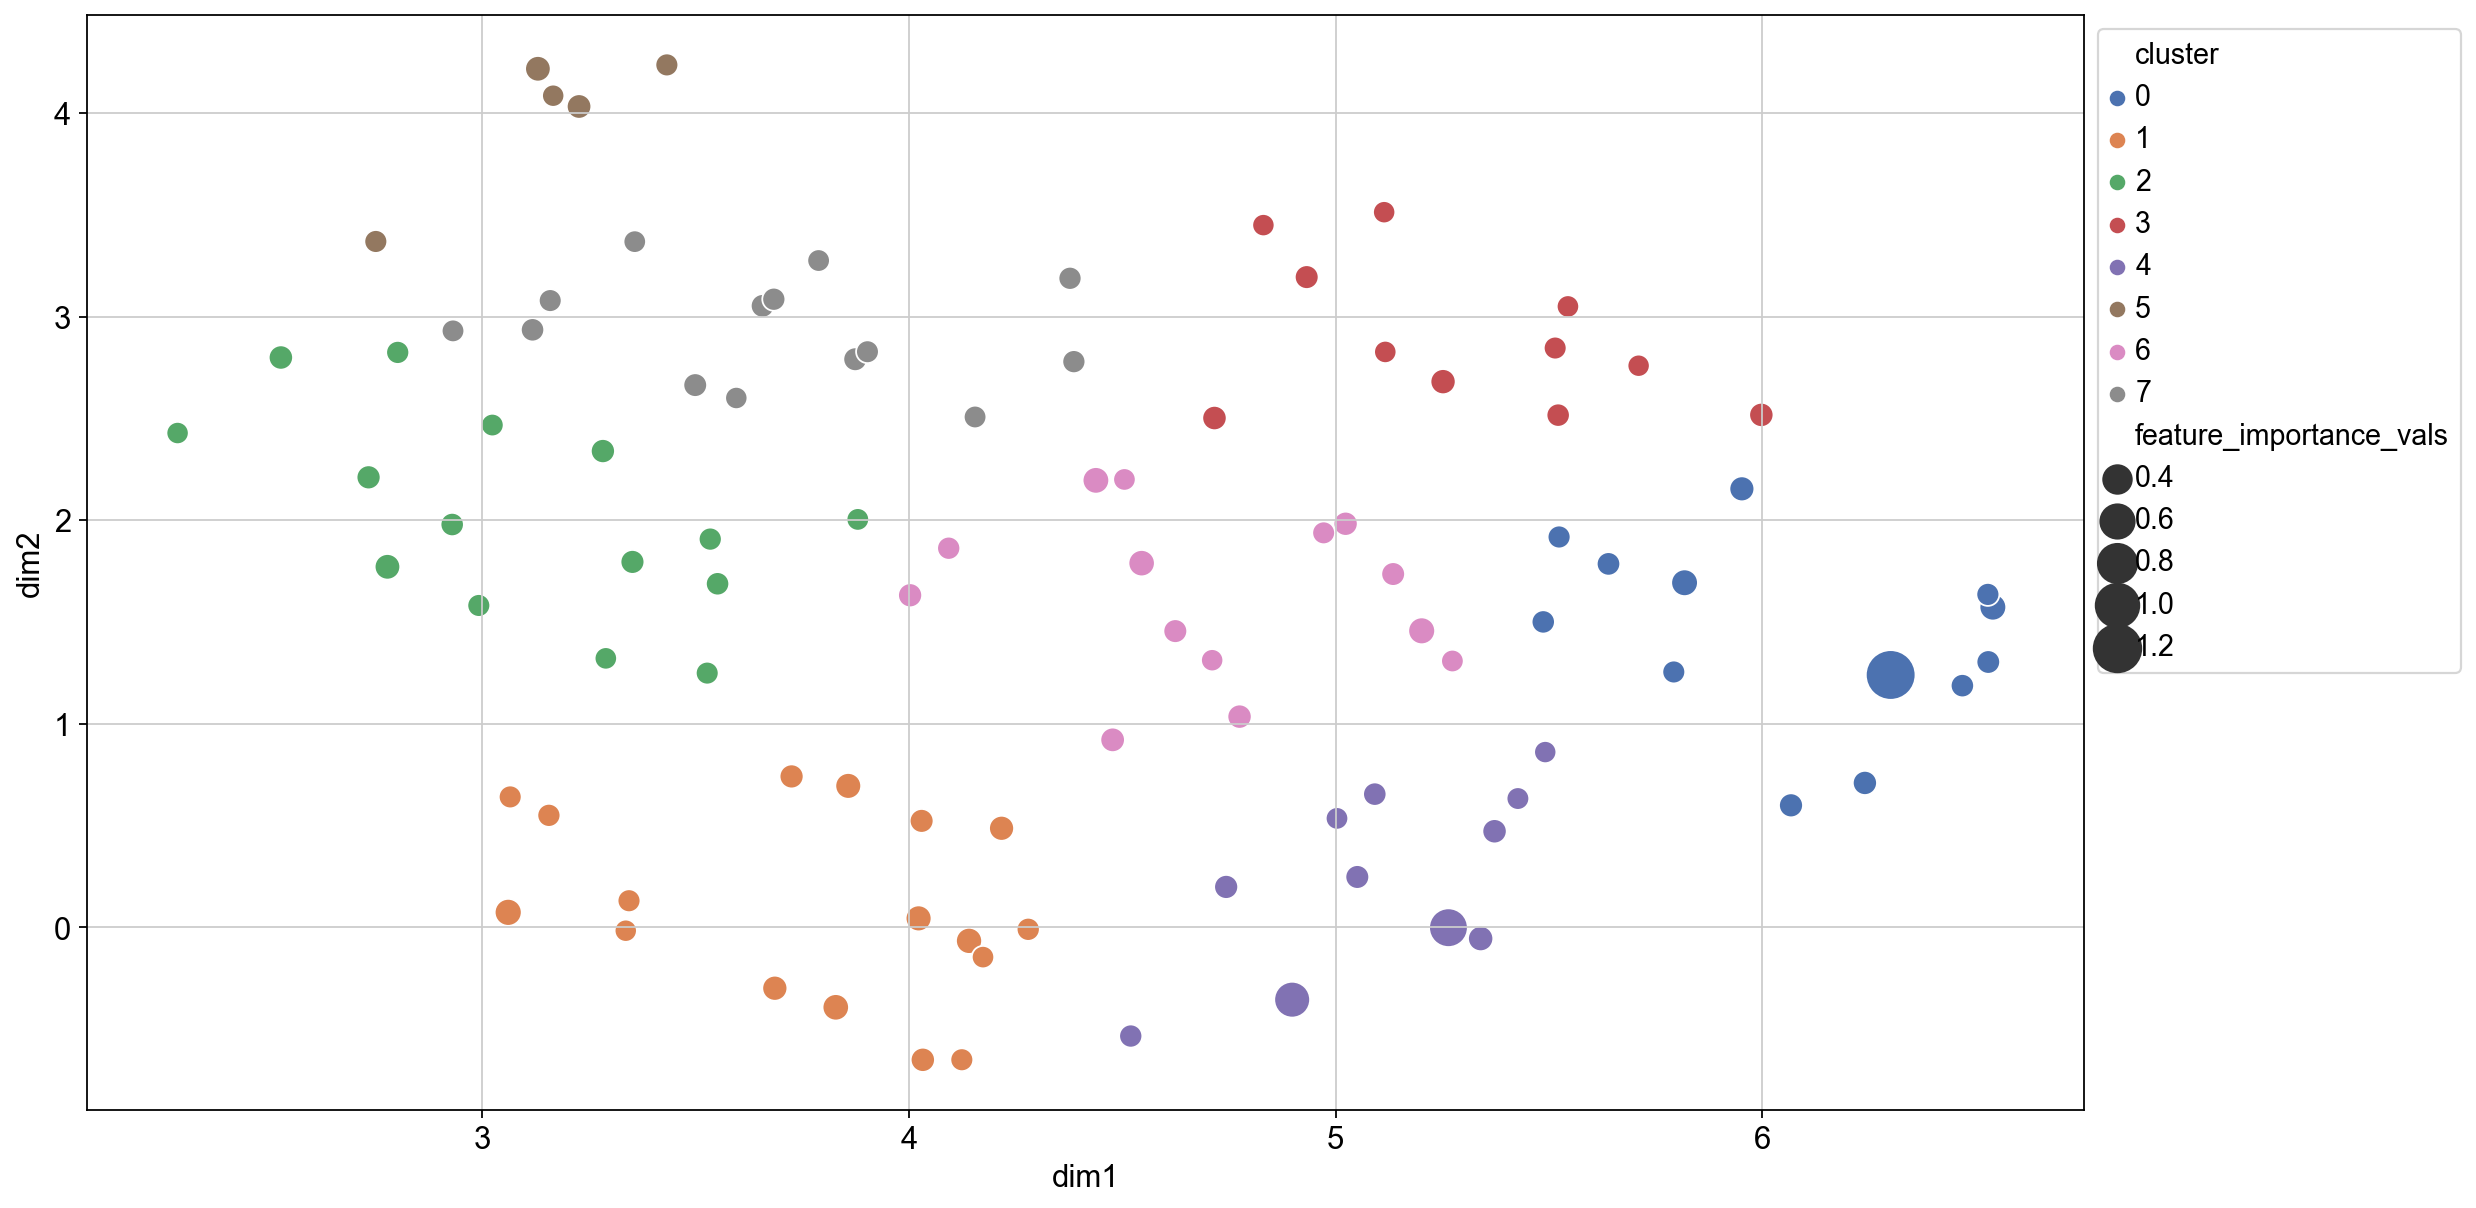

In [129]:
# Create a scatter plot of the principal components, colored by the "cluster" column
plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=clusters_df, x='dim1', y='dim2',
                     sizes=(100, 500),
                     palette='deep',
                      hue='cluster',
                        size='feature_importance_vals')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))